In [425]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import random
from torchvision.transforms import ToTensor, Compose, Resize, Normalize, ColorJitter
from torchvision.models import resnet18
from resnet18 import ResNet, BasicBlock
from resnet18_torchvision import build_model
from training_utils import train, validate
from utils import save_plots, get_data, datasets
from training_utils import train, validate

In [2]:
# Set seed.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

In [407]:
batch_size = 64
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [279]:
print('[INFO]: Training ResNet18 built from scratch...')
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=1000).to(device)
plot_name = 'resnet_scratch'

[INFO]: Training ResNet18 built from scratch...


In [401]:
def get_model():
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [402]:
model2, criterion2, optimizer2 = get_model()

/Users/darshangadkari/miniconda3/envs/yolo5/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/darshangadkari/miniconda3/envs/yolo5/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
train_loader, valid_loader = get_data(batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:10<00:00, 16867114.58it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
train_loader

In [280]:
IMAGENET_PATH = '/Users/darshangadkari/Documents/Homeopath/data'

In [290]:
# Data loading code
traindir = f'{IMAGENET_PATH}/trainDrSK/'
valdir = f'{IMAGENET_PATH}/testDrSK/'
normalize = Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

In [291]:
img_size = 224

In [403]:
train_dataset = datasets.ImageFolder(traindir, transform=Compose([
            Resize((img_size, img_size)),
            ToTensor()]))
len(train_dataset)

771

In [404]:
val_dataset = datasets.ImageFolder(valdir, transform=Compose([
            Resize((img_size, img_size)),
            ToTensor()]))
len(val_dataset)

437

In [411]:
batch_size

64

In [423]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False)

In [295]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

11,689,512 total parameters.
11,689,512 training parameters.


In [296]:
# Optimizer.
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Loss function.
criterion = nn.CrossEntropyLoss()

In [297]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

In [421]:
criterion

CrossEntropyLoss()

In [422]:
criterion2

BCELoss()

In [437]:
epochs = 4

In [450]:
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 2
Training


100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Validation


100%|██████████| 157/157 [00:08<00:00, 18.87it/s]


Training loss: 1.104, training acc: 72.114
Validation loss: 3.855, validation acc: 11.260
--------------------------------------------------
[INFO]: Epoch 2 of 2
Training


100%|██████████| 13/13 [00:46<00:00,  3.57s/it]


Validation


100%|██████████| 157/157 [00:08<00:00, 17.77it/s]

Training loss: 1.093, training acc: 70.169
Validation loss: 4.178, validation acc: 0.370
--------------------------------------------------


TRAINING COMPLETE


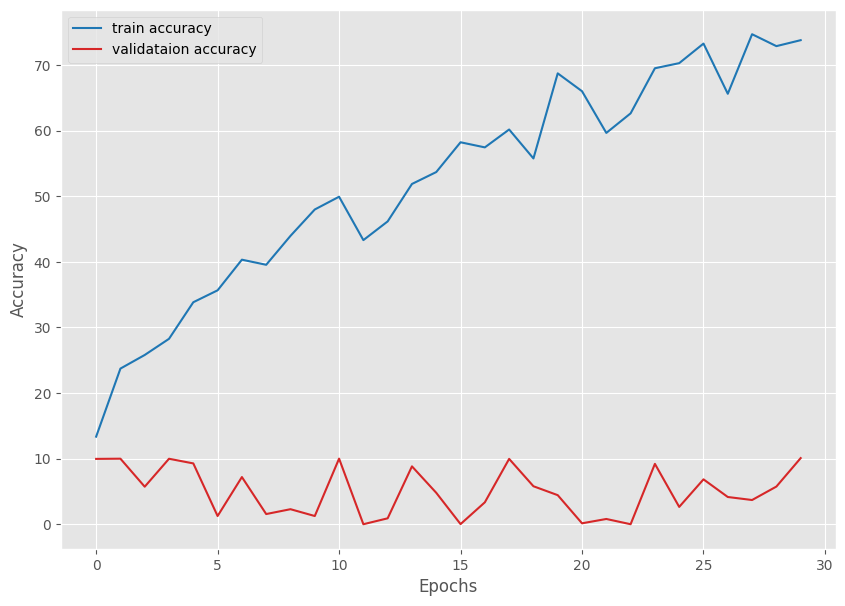

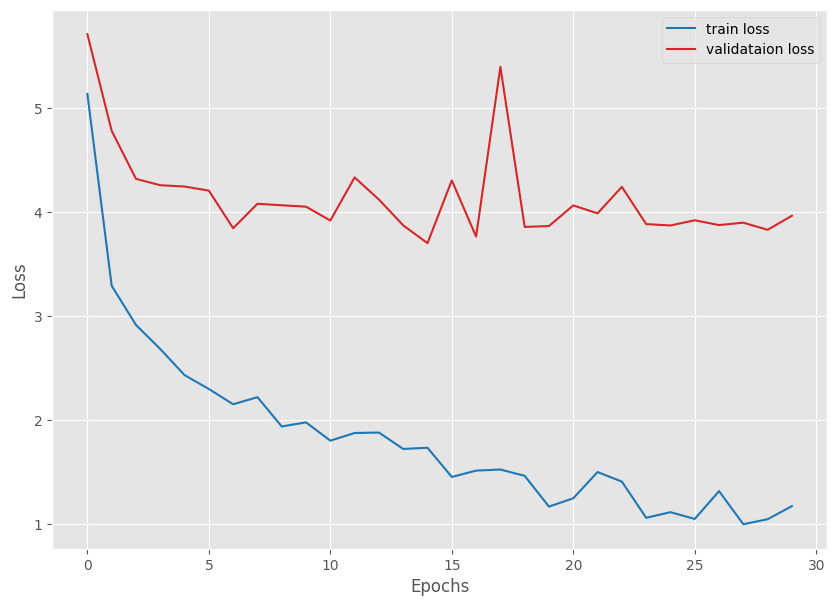

In [446]:
 # Save the loss and accuracy plots.
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name=plot_name
)
print('TRAINING COMPLETE')

In [100]:
torch.save(model, "resnet_model_224.pt")

In [302]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
model = torch.load("resnet_model_224.pt")

In [78]:
model1 = torch.load("/Users/darshangadkari/Documents/Homeopath/code/android-demo-app/PyTorchDemoApp/app/src/main/assets/resnet18.pt")

/Users/darshangadkari/miniconda3/envs/yolo5/lib/python3.10/site-packages/torch/serialization.py:1007: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [77]:
model1

RecursiveScriptModule(original_name=ChannelsLastModel)

In [105]:
from torchvision.transforms import (
    RandomResizedCrop, 
    RandomRotation,
    RandomHorizontalFlip,
    CenterCrop
    )

In [106]:
# Applying Transforms to the Data
image_transforms = { 
    'train': Compose([
        RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        RandomRotation(degrees=15),
        RandomHorizontalFlip(),
        CenterCrop(size=224),
        ToTensor(),
        normalize
    ]),
    'valid': Compose([
        Resize(size=256),
        CenterCrop(size=224),
        ToTensor(),
        normalize
    ]),
    'test': Compose([
        Resize(size=256),
        CenterCrop(size=224),
        ToTensor(),
        normalize
    ])
}

In [113]:
from PIL import Image
import matplotlib.pyplot as plt

In [140]:
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class :  ", {v:k for k,v in train_dataset.class_to_idx.items()}[topclass.cpu().numpy()[0][0]])

In [448]:
{v:k for k,v in train_dataset.class_to_idx.items()}

{0: 'Asteotic-Xerotic-dry-cracked Eczema',
 1: 'Atopic Dermatitis',
 2: 'Contact-Dermatitis or Eczema',
 3: 'Contact-Dermatitis or Eczema Acute Dermatitis',
 4: 'Contact-Dermatitis or Eczema chronic dermatitis',
 5: 'Eczema Trunk Generalized',
 6: 'Eczema Trunk Generalized Areolar Eczema',
 7: 'Eczema of Arms',
 8: 'Eczema of Arms Eczema of Fingertips',
 9: 'Eczema of Arms Eczema of Hands',
 10: 'Eczema of Genitals Eczema of Vulva',
 11: 'Eczema of Genitals Penile Eczema',
 12: 'Eczema of Genitals Scrotal Eczema',
 13: 'Eczema of Legs',
 14: 'Eczema of Legs Cracked heel or fissure',
 15: 'Eczema of Legs Eczema of Foot',
 16: 'Exfoliative Keratolysis',
 17: 'Facial Eczema',
 18: 'Facial Eczema Eczema of Ears',
 19: 'Facial Eczema Eczema of Eye-Lids',
 20: 'Ichthyosis',
 21: 'Neurotic Excoriation',
 22: 'Neurotic Excoriation Neurodermatitis ',
 23: 'Nummular Eczema',
 24: 'Pompholyx (hand foot)',
 25: 'Stasis-Venous Dermatitis',
 26: 'Subacute Eczema',
 27: 'anal excoriation',
 28: 'anal

Output class :   Eczema of Arms Eczema of Fingertips
Output class :   Eczema of Arms Eczema of Fingertips


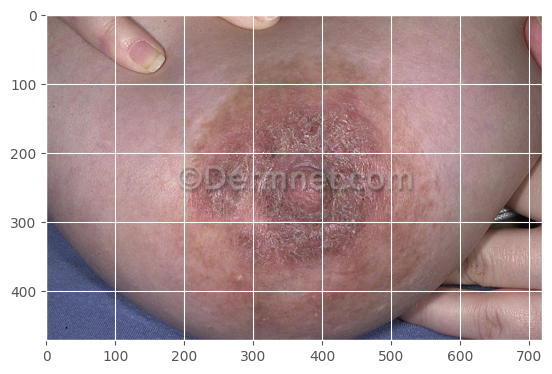

In [449]:
# predict(model=model, test_image_name=f'{IMAGENET_PATH}/train/Eczema Dyshidrosis/Dyshidrosis-51.jpg')
for i in [2,3]:
    predict(model=model, test_image_name=f'/Users/darshangadkari/Documents/Homeopath/data/trainDrSK/Eczema Trunk Generalized Areolar Eczema/eczema-areola-{i}.jpg')

In [329]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [146]:
trace_model = torch.jit.trace(model, torch.Tensor(1,3,224,224))

In [147]:
trace_model.save('resnet18_trace.pt')

In [327]:
scripted_module = torch.jit.script(model)
# Export full jit version model (not compatible lite interpreter), leave it here for comparison
scripted_module.save("resnet18_scripted.pt")
# Export lite interpreter version model (compatible with lite interpreter)
scripted_module._save_for_lite_interpreter("resnet18.pt")

In [328]:
{v:k for k,v in train_dataset.class_to_idx.items()}

{0: 'Asteotic-Xerotic-dry-cracked Eczema',
 1: 'Atopic Dermatitis',
 2: 'Contact-Dermatitis or Eczema',
 3: 'Contact-Dermatitis or Eczema Acute Dermatitis',
 4: 'Contact-Dermatitis or Eczema chronic dermatitis',
 5: 'Eczema Trunk Generalized',
 6: 'Eczema Trunk Generalized Areolar Eczema',
 7: 'Eczema of Arms',
 8: 'Eczema of Arms Eczema of Fingertips',
 9: 'Eczema of Arms Eczema of Hands',
 10: 'Eczema of Genitals Eczema of Vulva',
 11: 'Eczema of Genitals Penile Eczema',
 12: 'Eczema of Genitals Scrotal Eczema',
 13: 'Eczema of Legs',
 14: 'Eczema of Legs Cracked heel or fissure',
 15: 'Eczema of Legs Eczema of Foot',
 16: 'Exfoliative Keratolysis',
 17: 'Facial Eczema',
 18: 'Facial Eczema Eczema of Ears',
 19: 'Facial Eczema Eczema of Eye-Lids',
 20: 'Ichthyosis',
 21: 'Neurotic Excoriation',
 22: 'Neurotic Excoriation Neurodermatitis ',
 23: 'Nummular Eczema',
 24: 'Pompholyx (hand foot)',
 25: 'Stasis-Venous Dermatitis',
 26: 'Subacute Eczema',
 27: 'anal excoriation',
 28: 'anal

In [320]:
train_dataset.class_to_idx.keys()

dict_keys(['Asteotic-Xerotic-dry-cracked Eczema', 'Atopic Dermatitis', 'Contact-Dermatitis or Eczema', 'Contact-Dermatitis or Eczema Acute Dermatitis', 'Contact-Dermatitis or Eczema chronic dermatitis', 'Eczema Trunk Generalized', 'Eczema Trunk Generalized Areolar Eczema', 'Eczema of Arms', 'Eczema of Arms Eczema of Fingertips', 'Eczema of Arms Eczema of Hands', 'Eczema of Genitals Eczema of Vulva', 'Eczema of Genitals Penile Eczema', 'Eczema of Genitals Scrotal Eczema', 'Eczema of Legs', 'Eczema of Legs Cracked heel or fissure', 'Eczema of Legs Eczema of Foot', 'Exfoliative Keratolysis', 'Facial Eczema', 'Facial Eczema Eczema of Ears', 'Facial Eczema Eczema of Eye-Lids', 'Ichthyosis', 'Neurotic Excoriation', 'Neurotic Excoriation Neurodermatitis ', 'Nummular Eczema', 'Pompholyx (hand foot)', 'Stasis-Venous Dermatitis', 'Subacute Eczema', 'anal excoriation', 'anal excoriation anal eczema'])

In [353]:
# resize image to 256X256 then convert them to tensors
transform = Compose([
    Resize(256),
    ToTensor()
])

In [354]:
trainset = datasets.CIFAR10(root='./Data/trainset', download = True, transform = transform)

100%|██████████| 170498071/170498071 [00:09<00:00, 17532681.68it/s]


Extracting ./Data/trainset/cifar-10-python.tar.gz to ./Data/trainset


In [355]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, shuffle = True)

In [356]:
images_batch, labels_batch = iter(trainloader).__next__()

In [357]:
images_batch.shape

torch.Size([16, 3, 256, 256])

In [358]:
labels_batch.shape

torch.Size([16])

In [344]:
from torchvision.utils import make_grid

In [359]:
img = make_grid(images_batch)
img.shape

torch.Size([3, 518, 2066])

In [360]:
# switch the dimension set the number of channels to be 3rd
img = np.transpose(img, (1,2,0))
img.shape

torch.Size([518, 2066, 3])

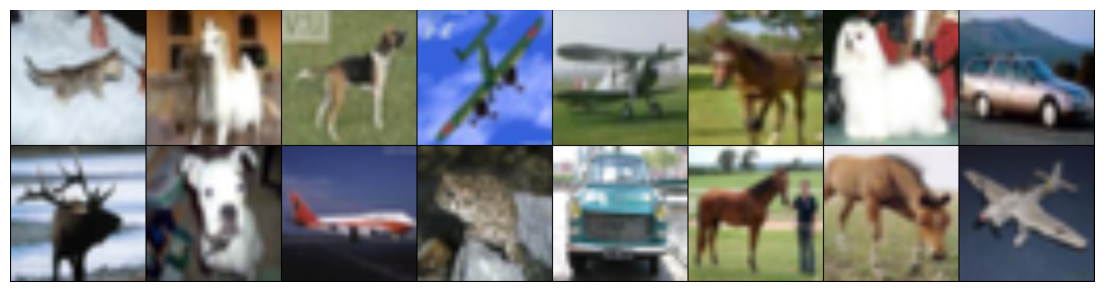

In [362]:
plt.figure(figsize=(14,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [363]:
# mean and std for the entire data set 
data_mean =[]
data_std = []

In [381]:
len(trainloader)

3125

In [364]:
for i, data in enumerate(trainloader,0):
    #extract images at index 0
    numpy_image = data[0].numpy()
   
    # mean and std separately for every channel 
    batch_mean = np.mean(numpy_image, axis =(0, 2, 3))
    batch_std = np.std(numpy_image, axis =(0, 2, 3))
    
    #append to the list
    data_mean.append(batch_mean)
    data_std.append(batch_std)

In [365]:
data_mean =np.array(data_mean) 
data_std = np.array(data_std)

In [366]:
data_mean.shape, data_std.shape

((3125, 3), (3125, 3))

In [367]:
data_mean = data_mean.mean(axis =0)
data_std  = data_std.mean(axis=0)

In [368]:
print(data_mean)
print(data_std)

[0.49159032 0.48234558 0.4467199 ]
[0.23830283 0.23490205 0.25274926]


In [370]:
#applying transforms on the dataset 
transform = Compose([
    Resize(256),
    RandomResizedCrop(224),
    ColorJitter(),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(data_mean,data_std)
])

In [371]:
trainset = datasets.CIFAR10(root='./Data/trainset', download = True, transform = transform)

Files already downloaded and verified


In [372]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, shuffle = True)

In [374]:
#acess one batch of the data 
images_batch, labels_batch = iter(trainloader).__next__()

In [375]:
images_batch.shape

torch.Size([16, 3, 224, 224])

In [376]:
# make a grid of our images
img = make_grid(images_batch)
img.shape

torch.Size([3, 454, 1810])

In [377]:
# switch the dimension set the number of channels to be 3rd
img = np.transpose(img, (1,2,0))
img.shape

torch.Size([454, 1810, 3])

In [378]:
#scale the pixel values to be in range 0 to 1
m, M = img.min(), img.max()
m, M

(tensor(-2.0367), tensor(2.2037))

In [379]:
# scale the normalized image 
img = (1/(abs(m) * M))*img+0.5

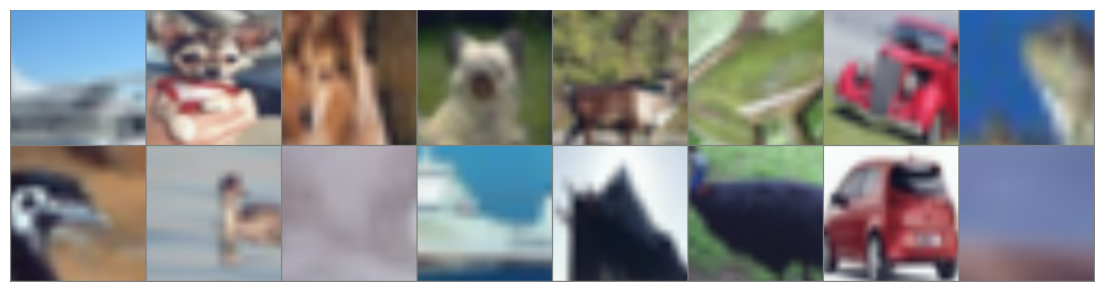

In [380]:
plt.figure(figsize=(14,10))
plt.imshow(img)
plt.axis('off')
plt.show()